# Explaining Parametric Additive Models

This tutorial will discuss **Parametric Additive Models** and how they generalize the linear models introduced previously.
Again, such models are rarely the most performant in practical applications, but we need to be able to explain them before
claiming to be able to explain more complex models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer, KBinsDiscretizer, OneHotEncoder

## Additive Models
### Definition

An additive model takes the following form

$$ h(x) = \omega_0 + \sum_{i=1}^d h_i(x_i),$$

where each *shape function* $h_i$ only depends on a single feature $x_i$. Note that linear models are a 
special case of additive models with $h_i(x_i) = \omega_i x_i$. By design, the contribution of each 
individual feature toward the prediction $h(x)$ is readily-available, which is why additive models are 
advertised as being transparent. In fact, it is tempting to define the importance of feature $x_i$ toward the prediction as

$$\text{Local Importance of } x_i = h_i(x_i).$$

As we saw previously with linear models, this intuitive definition can be subject to mathematical 
inconsistencies. We will discuss such inconsistencies in this tutorial and its sequel.

Fitting additive models requires defining a representation of the shape functions $h_i$. We
cannot allow any possible function $h_i$ since this would render the training intractable. There are two solutions : 
Parametric and non-parametric representations. In this tutorial, we will investigate the **Parametric Additive Models**, and the subsequent tutorial will investigate the alternative. In a parametric model, each 
shape function $h_i$ is modelled by first defining a basis of $M_i$ functions $\{h_{ij}\}_{j=1}^{M_i}$ along each feature $i$. 
The shape functions are then expressed as linear combinations of these bases.

$$h(x) = \omega_0 + \sum_{i=1}^d \sum_{j=1}^{M_i}\omega_{ij} h_{ij}(x_i).$$

## Toy Example

As done previously, we introduce advanced concepts on extremelly simple examples before increasing the 
complexity. We start with data involving a single input feature $x$.

Text(0, 0.5, 'y')

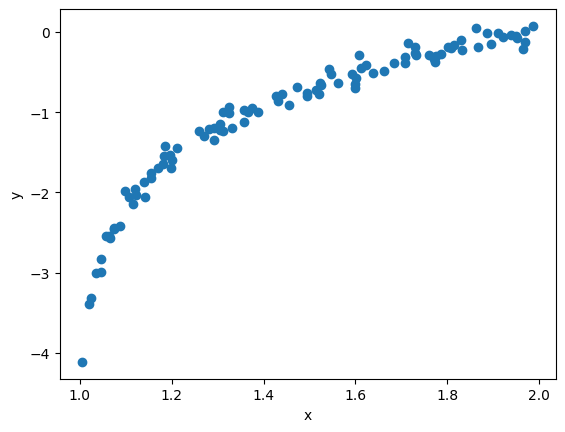

In [2]:
from pyfd.features import Features

# A single input feature
X = np.random.uniform(1, 2, size=(100, 1))
# Feature object
features = Features(X, ["x"], ["num"])
# The label is a non-linear function of x
y = np.log(X-0.99).ravel() + 0.1 * np.random.normal(size=(100,))
# A specific point of interest we want to explain
x_explain = np.array([1.1])

plt.figure()
plt.scatter(X.ravel(), y)
plt.xlabel("x")
plt.ylabel("y")

To fit this non-linear relationship, we need to define a basis of functions which can be combined to get a 
non-linear model. Here, we investigate two types of bases : Splines and Step functions. Feel free to run 
the notebook twice using either basis functions.

**Run with Splines**

(100, 4)


(0.0, 1.1)

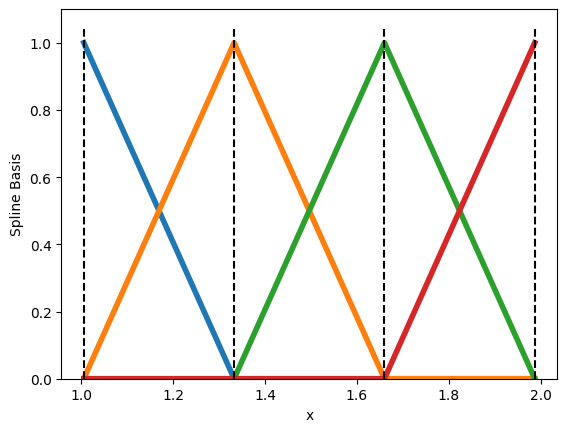

In [3]:
# Get a SplineTransformer
splines = SplineTransformer(n_knots=4, degree=1).fit(X)
# A (N, M_i) matrix of the splines evaluated on all datapoints
H = splines.transform(X)
print(H.shape)

# Plot the basis functions on the whole x axis
plt.figure()
line = np.linspace(X.min(), X.max(), 100).reshape((-1, 1))
H_line = splines.transform(line)
plt.plot(line, H_line, linewidth=4)
plt.xlabel("x")
plt.ylabel("Spline Basis")
knots = splines.bsplines_[0].t
plt.vlines(knots[1:-1], ymin=0, ymax=1.05, linestyles="dashed", color="k")
plt.ylim(0, 1.1)


**Run with Steps**

(100, 5)


(0.0, 1.1)

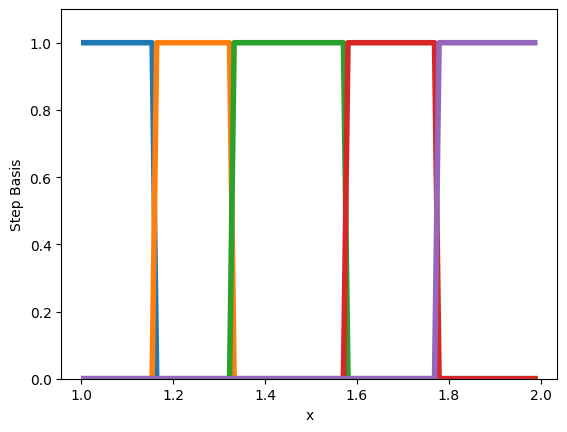

In [4]:
# Create Step functions
steps = KBinsDiscretizer(encode='onehot-dense').fit(X)
# A (N, M_i) matrix of the steps evaluated on all datapoints
H = steps.transform(X)
print(H.shape)

# Plot the basis functions over the whole x axis
plt.figure()
line = np.linspace(X.min(), X.max(), 100).reshape((-1, 1))
H_line = steps.transform(line)
plt.plot(line, H_line, linewidth=4)
plt.xlabel("x")
plt.ylabel("Step Basis")
plt.ylim(0, 1.1)

Here comes the magic. Once the basis functions have been evaluated on all data points, you can fit a 
parametric additive model by fitting a classical linear model on the `H` array instead of the orignal `X` 
array. To make it more fun, lets fit this Linear Model ourselves using the Normal Equation (*i.e* the closed-form solution
to the least-square)

$$ \omega = (H^T H)^{-1}H^T y.$$

In [5]:
from scipy.linalg import solve
# Augment the matrix to include an intercept
H_augmented = np.column_stack((np.ones(100), H))
omega = solve(H_augmented.T.dot(H_augmented), H_augmented.T.dot(y))

/tmp/ipykernel_22621/3910720931.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=5.92119e-18): result may not be accurate.
  omega = solve(H_augmented.T.dot(H_augmented), H_augmented.T.dot(y))


**This does not work**. The reason being that the basis functions are overparametrized : they sum up to $1$ for 
any $x$.

In [6]:
H.sum(1)[:20]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

The spline and step basis functions are redundant with 
the intercept $\omega_0$. As a result, there is no **unique** solution to the least-square problem. 

There are three ways to adress this problem:
- Remove one of the basis functions.
- Ignore the intercept term in the regression. This will not be sufficient when there are various input features.
- Slightly regularize the model to impose a preference on *low-norm* solutions.

We now present how to remove a spline/step basis function.

**Run with Splines**

(100, 3)


(0.0, 1.1)

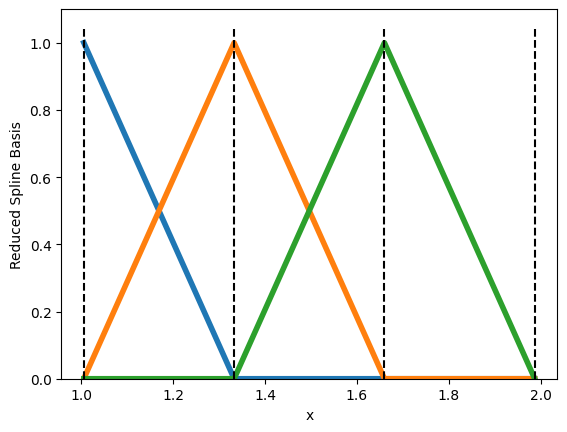

In [7]:
# The splines transformer removes the last basis via its `include_bias=False` parameter
splines = SplineTransformer(include_bias=False, n_knots=4, degree=1).fit(X)
H = splines.transform(X)
print(H.shape)

# Plot the basis functions over the whole x axis
plt.figure()
H_line = splines.transform(line)
plt.plot(line, H_line, linewidth=4)
plt.xlabel("x")
plt.ylabel("Reduced Spline Basis")
knots = splines.bsplines_[0].t
plt.vlines(knots[1:-1], ymin=0, ymax=1.05, linestyles="dashed", color="k")
plt.ylim(0, 1.1)

**Run with Steps**

(100, 4)


(0.0, 1.1)

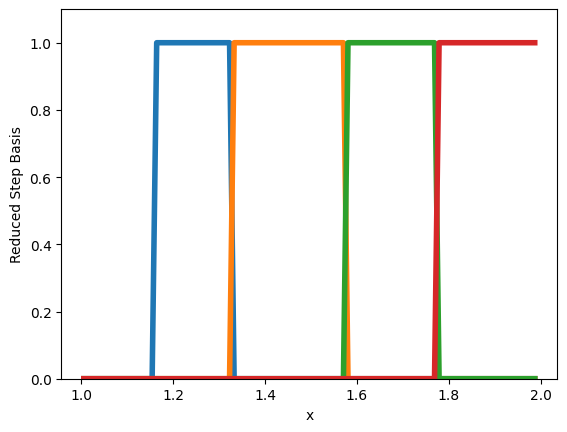

In [8]:
# The OneHotEncoder drops the first basis via its `drop='first'` parameter.
steps = Pipeline([('bins', KBinsDiscretizer(encode='ordinal')), 
                  ('ohe', OneHotEncoder(sparse_output=False, drop='first'))]).fit(X)
H = steps.transform(X)
print(H.shape)

# Plot the basis functions over the whole x axis
plt.figure()
H_line = steps.transform(line)
plt.plot(line, H_line, linewidth=4)
plt.xlabel("x")
plt.ylabel("Reduced Step Basis")
plt.ylim(0, 1.1)

Removing one of the basis function will solve the overparametrization problem, but it introduces another issue. Remember that we defined $h_i(x_i)$ as the local importance of feature $x_i$ towards the prediction $h(x)$. 
But, when we remove a basis, the feature values $x_i$ covered by this basis will be attributed a null importance!

In [9]:
# For some datum, all basis evaluate to zero meaning that
# the shape function h_i(x_i) will systematically be 0.
H.sum(1)[:20]

array([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

Even worse, the choice of which basis to remove is up to the scikit-learn API: the last spline basis is removed while the first step basis is removed.

To solve these inconsistencies, we again resort to framing local explanability as a relative concept. 
Instead of explaining the prediction $h(x)$, we explain the Gap between the prediction and the average prediction over the background $\mathcal{B}$

$$G(h, x, \mathcal{B}) = h(x) - \mathbb{E}_{z\sim\mathcal{B}}[h(z)].$$

`PyFD` advocates reporting the local importance of a feature as follows

$$\text{Local Importance of } x_i = h_i(x_i) - \mathbb{E}_{z\sim\mathcal{B}}[h_i(z_i)].$$

These local importance scores satisfy the crucial property of summing up to the Gap

$$\sum_{i=1}^d \text{Local Importance of } x_i = G(h, x, \mathcal{B})$$

so they can be seen as *explaining* the Gap. Moreover, these quantities are invariant to the choice of 
methodology employed to deal with overparametrization, as we shall see. 

**Run with Splines**

In [10]:
from pyfd.decompositions import get_components_linear

# The point to explain
foreground = x_explain.reshape((1, -1))
# The background is the whole data
background = X

# Option 1 : Include the intercept and remove a basis
model_1 = Pipeline([('spline', SplineTransformer(include_bias=False)), 
                    ('predictor', LinearRegression(fit_intercept=True)) ]).fit(X, y)
decomp_1 = get_components_linear(model_1, foreground, background, features)
print(f"Local Importance of x_explain : {decomp_1[(0,)][0]:.2f}")

Local Importance of x_explain : -1.14


In [11]:
# Option 2 : Exclude the intercept but keep all basis functions
model_2 = Pipeline([('spline', SplineTransformer(include_bias=True)), 
                    ('predictor', LinearRegression(fit_intercept=False)) ]).fit(X, y)
decomp_2 = get_components_linear(model_2, foreground, background, features)
print(f"Local Importance of x_explain : {decomp_2[(0,)][0]:.2f}")

Local Importance of x_explain : -1.14


In [12]:
# Option 3 : Stay overparametrized but slightly regularize the linear model
model_3 = Pipeline([('spline', SplineTransformer(include_bias=True)), 
                    ('predictor', Ridge(fit_intercept=True, alpha=1e-4)) ]).fit(X, y)
decomp_3 = get_components_linear(model_3, foreground, background, features)
print(f"Local Importance of x_explain : {decomp_3[(0,)][0]:.2f}")

Local Importance of x_explain : -1.14


Text(0, 0.5, 'y')

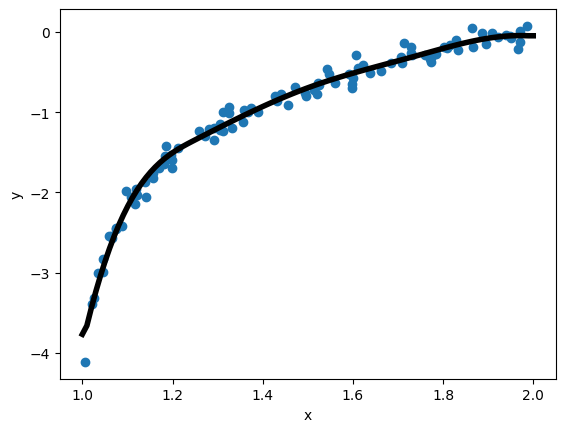

In [13]:
plt.figure()
line = np.linspace(1, 2, 100)
plt.scatter(X.ravel(), y)
plt.plot(line, model_1.predict(line.reshape((-1, 1))), "k", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")

**Run with Steps**

In [14]:
# The point to explain
foreground = x_explain.reshape((1, -1))
# The background is the whole data
background = X

# Option 1 : Include the intercept and remove a basis
model_1 = Pipeline([('bin', KBinsDiscretizer(encode='ordinal')),
                    ('ohe', OneHotEncoder(sparse_output=False, drop='first')),
                    ('predictor', LinearRegression(fit_intercept=True)) ]).fit(X, y)
decomp_1 = get_components_linear(model_1, foreground, background, features)
print(f"Local Importance of x_explain : {decomp_1[(0,)][0]:.2f}")

Local Importance of x_explain : -1.48


In [15]:
# Option 2 : Exclude the intercept and keep all basis functions
model_2 = Pipeline([('basis', KBinsDiscretizer(encode='onehot-dense')), 
                    ('predictor', LinearRegression(fit_intercept=False)) ]).fit(X, y)
decomp_2 = get_components_linear(model_2, foreground, background, features)
print(f"Local Importance of x_explain : {decomp_2[(0,)][0]:.2f}")

Local Importance of x_explain : -1.48


In [16]:
# Option 3 : Stay overparametrized but slightly regularize the linear model
model_3 = Pipeline([('basis', KBinsDiscretizer(encode='onehot-dense')), 
                    ('predictor', Ridge(fit_intercept=True, alpha=1e-4)) ]).fit(X, y)
decomp_3 = get_components_linear(model_3, foreground, background, features)
print(f"Local Importance of x_explain : {decomp_3[(0,)][0]:.2f}")

Local Importance of x_explain : -1.48


Text(0, 0.5, 'y')

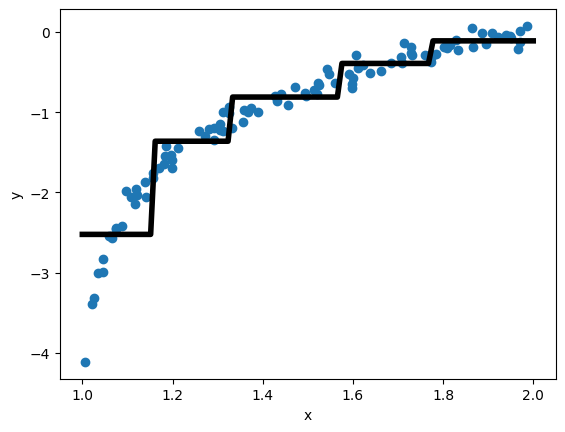

In [17]:
plt.figure()
line = np.linspace(1, 2, 100)
plt.scatter(X.ravel(), y)
plt.plot(line, model_2.predict(line.reshape((-1, 1))), "k", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")

## BikeSharing
In this section, we will use `PyFD` to explain an additive model fitted to predict the number of bike rentals 
given time and weather features. This model will make use of both spline and step basis functions.

In [18]:
import os
from joblib import load, dump
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from pyfd.data import get_data_bike
from pyfd.plots import setup_pyplot_font, bar, partial_dependence_plot

We first load the data and then fit a `Ridge`linear
model on top of a `Pipeline` that does the following
- Keeps the features `yr`, `holiday`, `workingday`, `weathersit`, and `windspeed` intact. As such, the corresponding shape function is $h_i(x_i)=\omega_i x_i$.
- Encodes `mnth`, `hr` and `weekday` as **step** basis functions.
- Encodes `temp` and `hum` as **spline** basis functions.

To avoid overparametrization (and save some memory) we will be removing one basis along each input feature.

In [19]:
# Load the data
X, y, features = get_data_bike()
features.summary()
d = len(features)
features.feature_objs[1].cats = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
features.feature_objs[4].cats = ["Mon", "Thu", "Wed", "Thu", "Fri", "Sat", "Sun"]

|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | yr                 | ordinal            | 2          | [0]              |
| 1 | mnth               | ordinal            | 12         | [1]              |
| 2 | hr                 | num_int            | 24         | [2]              |
| 3 | holiday            | bool               | 2          | [3]              |
| 4 | weekday            | ordinal            | 7          | [4]              |
| 5 | workingday         | bool               | 2          | [5]              |
| 6 | weathersit         | num_int            | 4          | [6]              |
| 7 | temp               | num                | inf        | [7]              |
| 8 | hum                | num                | inf        | [8]              |
| 9 | windspeed          | num                | inf        | [9]              |
----------------------------------------

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The step basis functions
step_basis = OneHotEncoder(sparse_output=False, drop='first')
# The spline basis functions
spline_basis = SplineTransformer(include_bias=False)
# Concatenate the basis functions
encoder = ColumnTransformer([('identity', FunctionTransformer(), [0, 3, 5, 6, 9]),
                             ('ohe', step_basis, [1, 2, 4]),
                             ('splines', spline_basis, [7, 8])
                            ])
model = Pipeline([('encoder', encoder), ('scaler', StandardScaler()), ('predictor', Ridge())])
model

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('identity',
                                                  FunctionTransformer(),
                                                  [0, 3, 5, 6, 9]),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [1, 2, 4]),
                                                 ('splines',
                                                  SplineTransformer(include_bias=False),
                                                  [7, 8])])),
                ('scaler', StandardScaler()), ('predictor', Ridge())])

**The cells bellow only need to be run once, since the predictor will be saved locally. If you have already 
trained the model, skip this part.**

In [ ]:
# We do a grid search to find the optimal degree of splines and their number of knots
grid = {"predictor__alpha": np.logspace(-4, 4, 40),
        'encoder__splines__n_knots' : [3, 4, 5, 6],
        'encoder__splines__degree' : [1, 2, 3]}

search = GridSearchCV(
    model,
    cv=KFold(),
    scoring='neg_root_mean_squared_error',
    param_grid=grid,
    verbose=2
)
search.fit(X_train, y_train)

In [33]:
# Recover the optimal CV model
model = search.best_estimator_
res = search.cv_results_
cv_perf = np.nan_to_num(-res['mean_test_score'], nan=1e10)
best_idx = np.argmin(cv_perf)

In [ ]:
plt.figure()
plt.scatter(res['param_predictor__alpha'], cv_perf, c=res['param_encoder__splines__degree'], alpha=0.75)
plt.plot(res['param_predictor__alpha'][best_idx], cv_perf[best_idx], 'r*', markersize=10, markeredgecolor='k')
plt.xlabel("Regularisation alpha")
plt.ylabel("Cross-Validated RMSE")
plt.xscale('log')
plt.ylim(97, 120)
plt.colorbar()

In [35]:
# Pickle the model
dump(model, os.path.join("models", "bike_splines.joblib"))

['models/bike_splines.joblib']

**Start from here if you have already trained the model**

In [21]:
# Load the model
model = load(os.path.join("models", "bike_splines.joblib"))
print(model.score(X_test, y_test))

0.6964294242746683


In [22]:
# Compute the local feature importance
# foreground is the set of all points we which to explain
foreground = X
# background is the distribution of reference points
background = X
# Here we compute the decomposition "Imp x_i = h_i(x_i) - E_{z ~ Background}[h_i(z_i)]"
components = get_components_linear(model, foreground, background, features)
print(components.keys())
print(components[(0,)].shape)

dict_keys([(), (0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)])
(17379,)


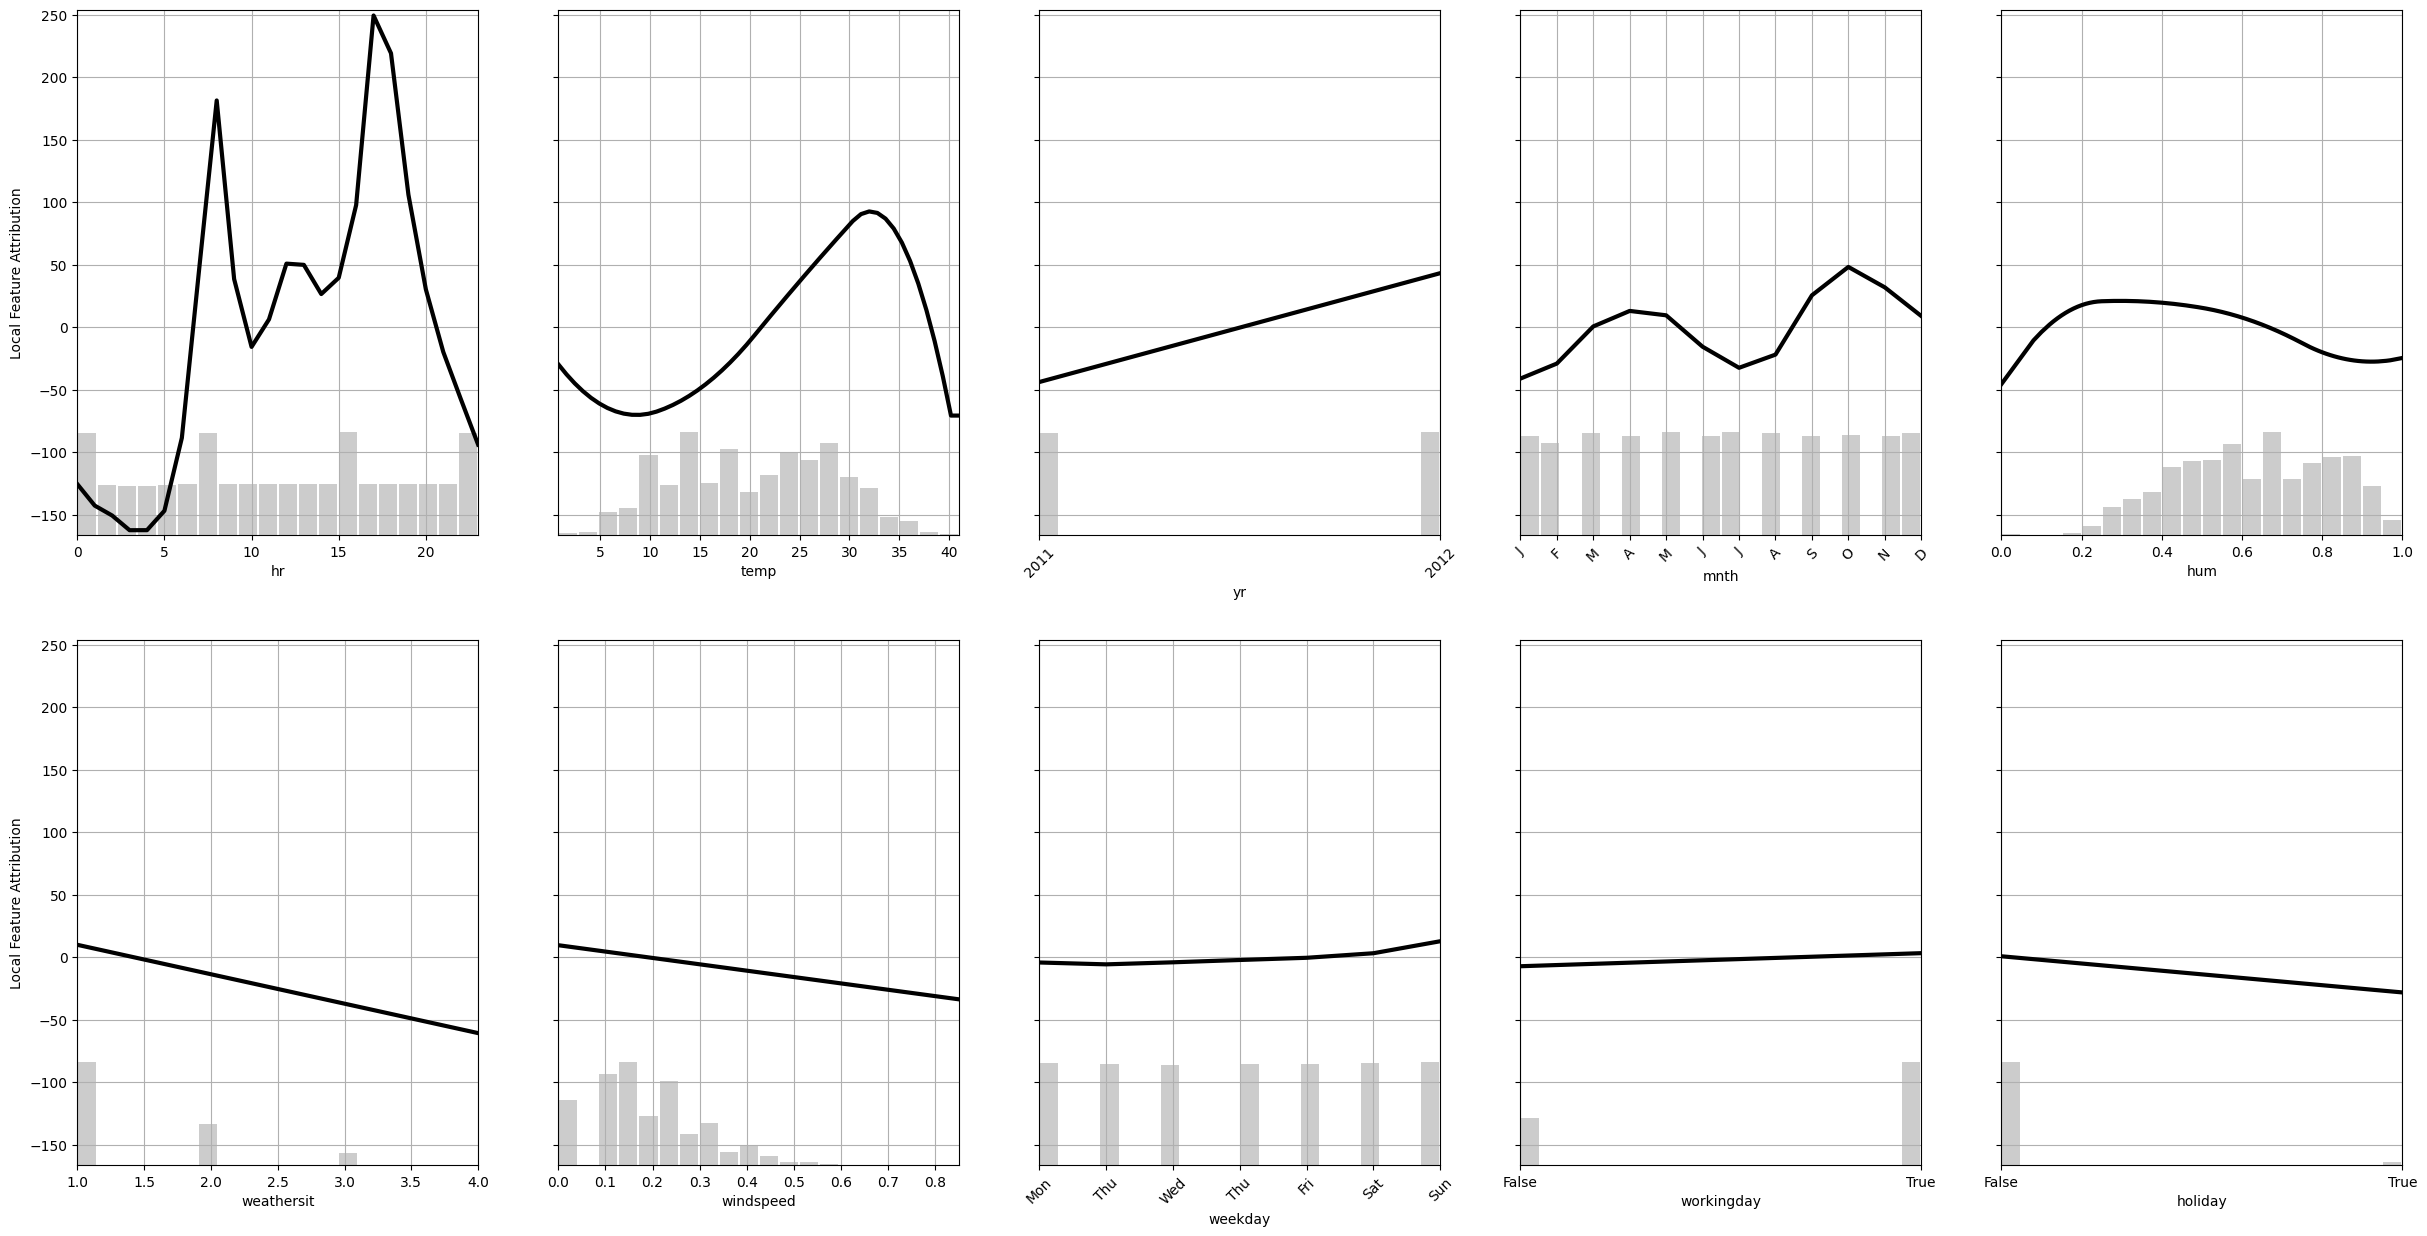

In [23]:
partial_dependence_plot(components, foreground, features, plot_hist=True, n_cols=5, figsize=(30, 15))

We now show the local feature importance of randomly chosen examples from the dataset

##### Instance 0 #####


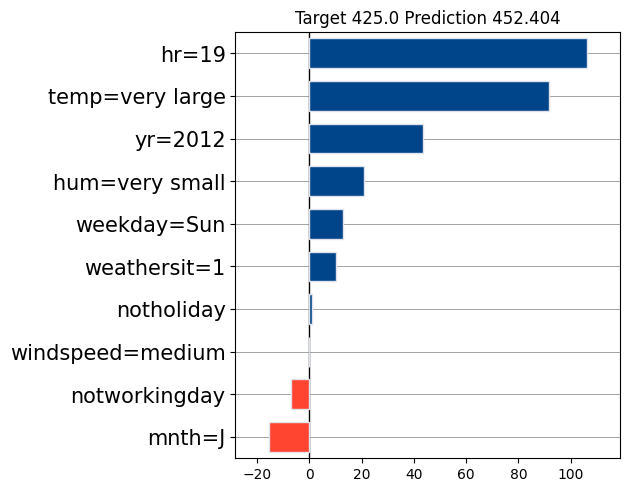

##### Instance 2 #####


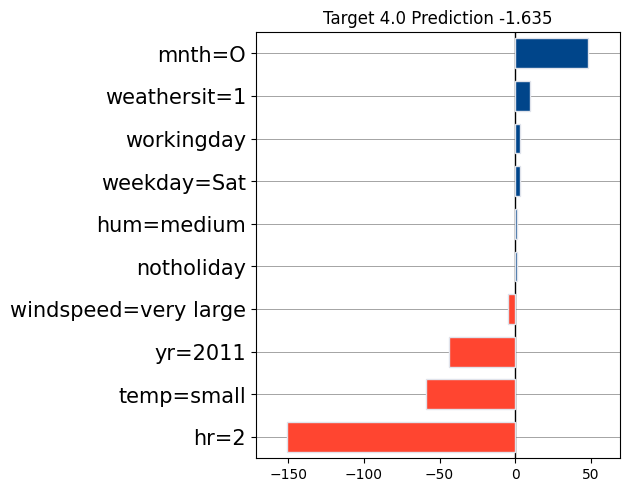

##### Instance 4 #####


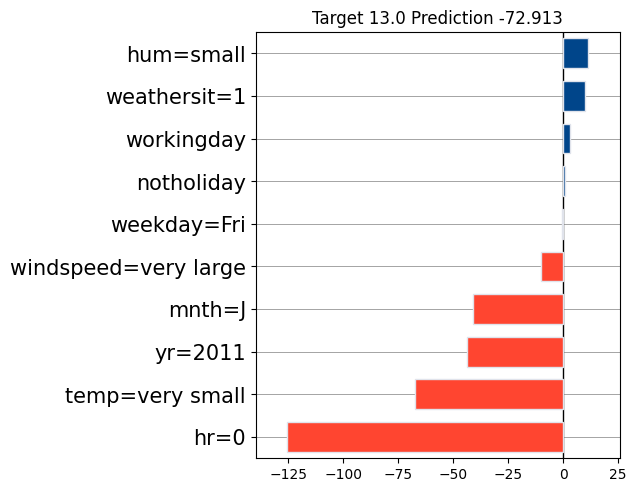

##### Instance 6 #####


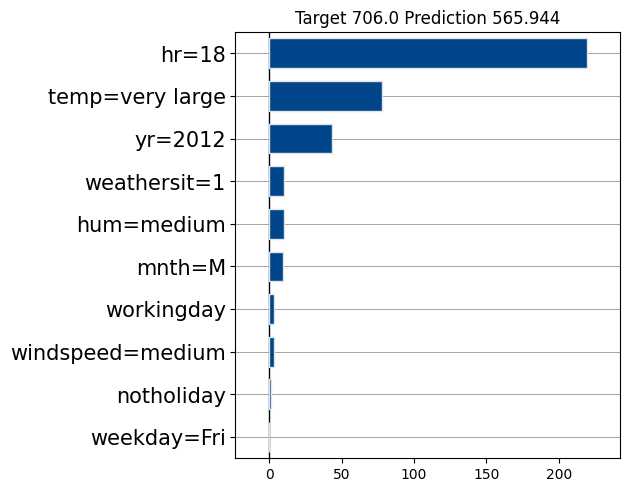

##### Instance 8 #####


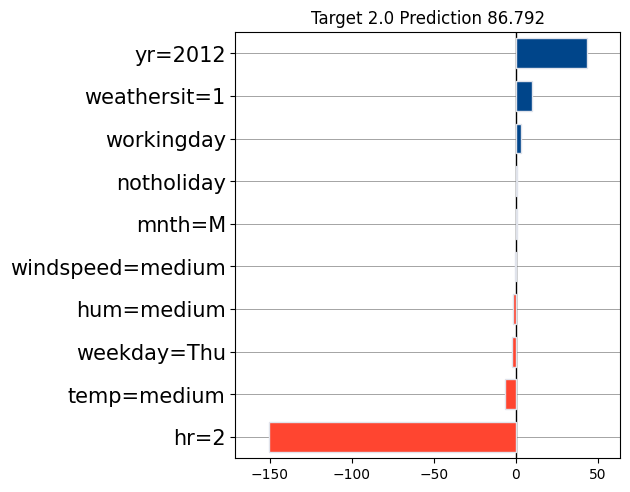

##### Instance 10 #####


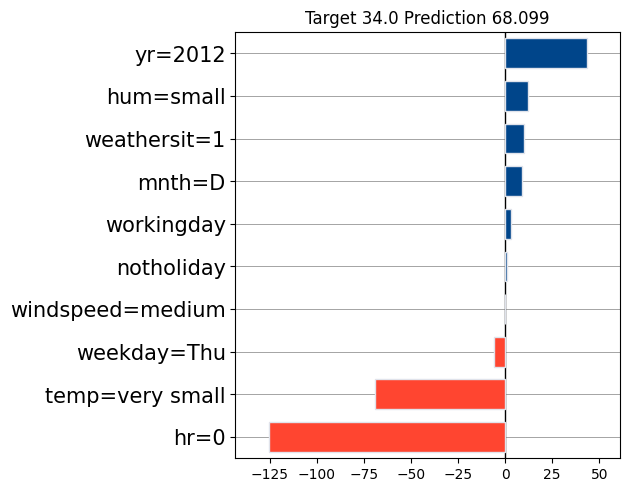

##### Instance 12 #####


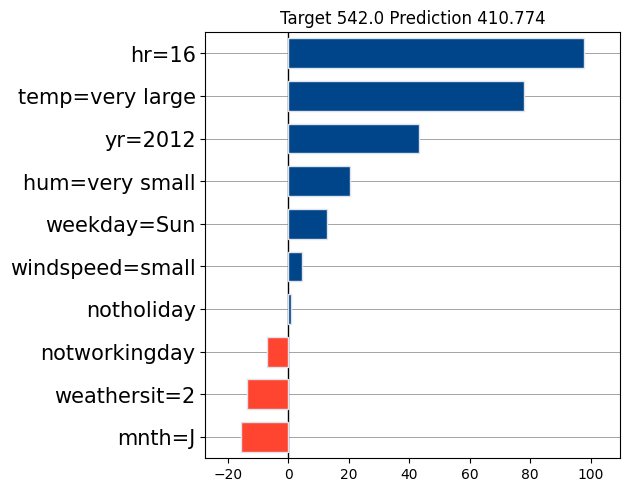

##### Instance 14 #####


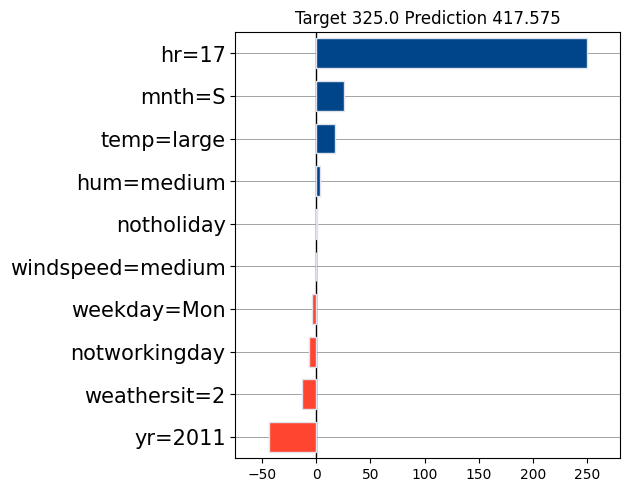

##### Instance 16 #####


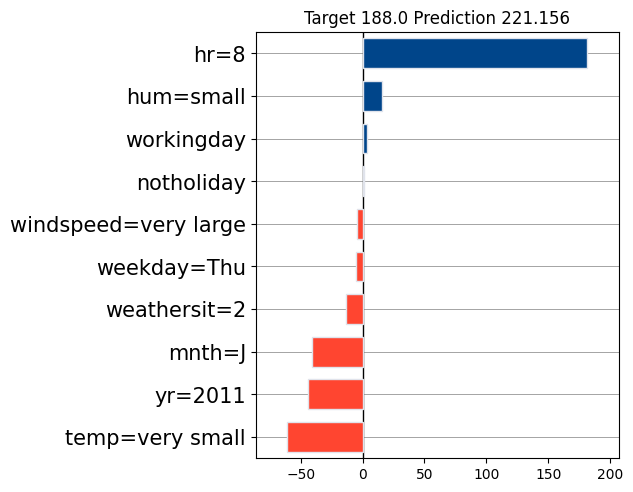

##### Instance 18 #####


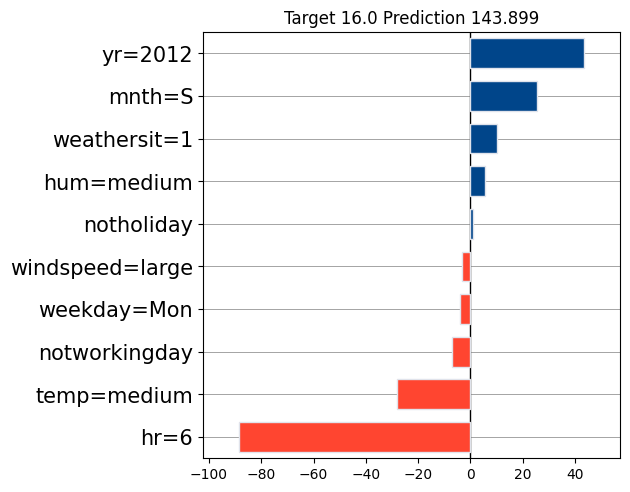

In [24]:
for idx in range(0, 20, 2):
    print(f"##### Instance {idx} #####")
    # Choose an instance
    x_explain = X[[idx]]
    x_map = features.print_value(x_explain.ravel())

    # Predictions and explanation
    pred = model.predict(x_explain)
    bar(np.array([components[(i,)][idx] for i in range(d)]), x_map)
    plt.title(f"Target {y[idx]} Prediction {pred[0]:.3f}")
    plt.show()

The local feature importance shown earlier is evaluated on the distribution on datapoints. To get
higher-resolution plots, it is also possible to define the `foreground` as a `np.linspace`.

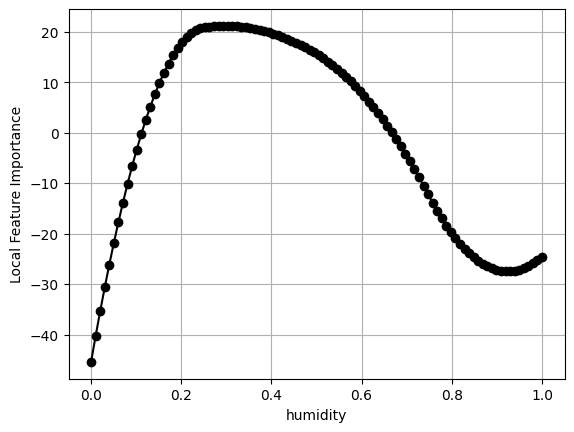

In [25]:
# We study humidity
feature_idx = 8
foreground = np.linspace(0, 1, 100)
one_component = get_components_linear(model, foreground, background, features=features.select([8]))
plt.figure()
plt.plot(foreground, one_component[(0,)], 'k-o')
plt.xlabel("humidity")
plt.ylabel("Local Feature Importance")
plt.grid('on')

Finally, we compute the global feature importance via 

$$ \Phi_i(h) = \sqrt{\mathbb{E}_{x\sim \mathcal{B}}[(\text{Local Importance of } x_i)^2]}.$$

An important characteristic of `PyFD` is that global feature importance is computed by **aggregating**
local feature importance across the data. This aggregation is left to the user.

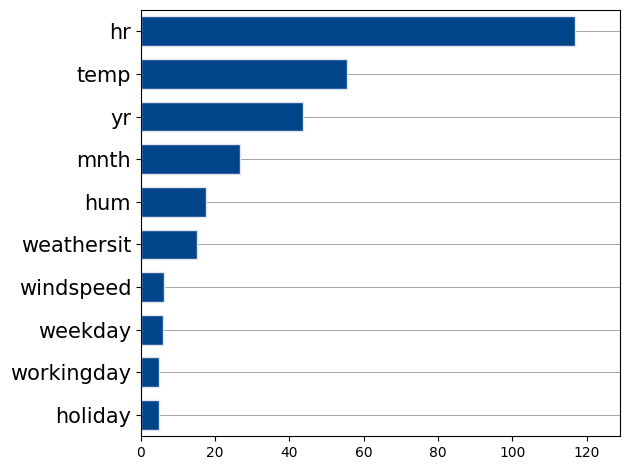

In [26]:
GFI = np.stack([(components[(i,)]**2).mean() for i in range(d)])
GFI = np.sqrt(GFI)
features_names = features.names()
bar(GFI, features_names)